In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import find_peaks

In [2]:
!pip install peakutils
from peakutils import baseline

In [134]:
def derivative(x,y):
    print("Hello from derivative")
    print(x.iloc[0])
    
    print(len(x)-1)
    derivative=[]
    
    for i in range(len(x)):
        if i==0 or i==len(x)-1:
            derivative.append(0);
        else:
            d=-0.5*(((y.iloc[i+1]-y.iloc[i])/(x.iloc[i+1]-x.iloc[i]))+((y.iloc[i]-y.iloc[i-1])/(x.iloc[i]-x.iloc[i-1])))
            derivative.append(d);
    
    #Graficamos
    #plt.plot(x, derivative)
    #plt.gca().invert_xaxis()
    #plt.figure(figsize=(25,15))
    #plt.show()
    
    return derivative

In [240]:
def analiza(data):
    print("Holi estás en analiza")
    
    #Nos quedamos con la sección de huellas dactilares
    
    result = data.dtypes

    print("Output:")
    print(result)
    
    data.drop(data[data['No. onda'] >= 2000].index, inplace = True)
    print(data)
    
    #Graficamos huellas dactilares
    #plt.plot(data['No. onda'], data['Absorbancia'])
    #plt.gca().invert_xaxis()
    #plt.figure(figsize=(25,15))

    #plt.show()
    
    #Derivamos por primera vez
    print("~PRIMER DERIVADA~")
    dev1=derivative(data['No. onda'],data['Absorbancia'])
    #print(dev1)
    
    #Pasamos dev1 de list a dataframe
    data['Primer derivada']= dev1
    #print(data)
    
    #Derivamos por segunda vez
    print("~SEGUNDA DERIVADA~")
    dev2=derivative(data['No. onda'],data['Primer derivada'])
    #print(dev2)
    
    #Pasamos dev2 de list a dataframe
    data['Segunda derivada']= dev2
    #print(data)
    
    #Sacamos n3, n2, n4
    #Encontramos los picos
    #print('los valores más grandes que están en el pico n3', data.nlargest(3, 'Absorbancia')) #<---Saca los valores más grandes que están en el pico n3
    
    
    peaks2,_= find_peaks(data['Absorbancia'], prominence=0.052)      # BEST!
    #Caso particular 800 agregar el pico en 625 -falta de tiempo-
    #print(len(peaks2))
    
    if len(peaks2)<3:
        print("Entramos al if")
        peaks2=np.append(peaks2,625)
        
        
    print('Picos usando peaks: ',peaks2)
    print('No de onda:\n',data.iloc[peaks2])
    
    #Obtenemos la Absorbancia corregida.
    bl=baseline(data['Absorbancia'], deg=3)
    plt.plot(data['No. onda'], bl, label='Corrección usando baseline deg=3')
    plt.plot(data['No. onda'], data['Absorbancia'], label='Absorbancia (AB)')
    
    #Graficando la Absorbancia corregida.
    plt.plot(data['No. onda'], data['Absorbancia']-bl, label='Absorbancia corregida')
    plt.title('Absorbancia vs. absorbancia corregida')
    plt.xlabel('No. onda (cm-1)')
    plt.ylabel('Absorbancia')
    plt.gca().invert_xaxis()
    plt.legend(loc="lower right", prop = { "size": 7})
    plt.show()
    
    #Guardamos la absorbancia corregida
    data['Correccion absorbancia']= data['Absorbancia']-bl
    #print(data)
    
    peaks3,_= find_peaks(data['Correccion absorbancia']*-1, height=-0.015)      # BEST!
    #print('Picos: \n',peaks3)
    #Datos de la absorbancia corregida.
    
    indexes=[]
    for n in peaks2:
        pek=peaks3-n
        #print("-------------------------------------------------------")
        #print("Valor de n",n)
        
        #print(pek)
        
        inicio=max([k for k in pek if k<0])
        fin=min([k for k in pek if k>0])
        
        for index, item in enumerate(pek):
            if item == inicio or item ==fin:
                indexes.append(index)
    #print(indexes)
    indexes2=[]
    for n in indexes:
        #print("pek[n]",peaks3[n])
        indexes2.append(peaks3[n])
    #print('No de onda:\n',data.iloc[indexes2])
    
    #Graficando la Absorbancia corregida.
    plt.plot(data['No. onda'],data['Correccion absorbancia']*-1,  label='Absorbancia corregida')
    plt.plot(data['No. onda'].iloc[indexes2], data['Correccion absorbancia'].iloc[indexes2]*-1, 'bo', label='Segmentos')
    plt.plot(data['No. onda'].iloc[peaks2], data['Correccion absorbancia'].iloc[peaks2]*-1, 'go', label='Máximos')
    plt.plot(data['No. onda'].iloc[peaks3], data['Correccion absorbancia'].iloc[peaks3]*-1, 'rx')
    
    #Verificamos visualmente qué estamos obteniendo
    plt.title('Absorbancia corregida')
    plt.xlabel('No. onda (cm-1)')
    plt.ylabel('Absorbancia')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.legend(loc="upper left", prop = { "size": 7})
    plt.show()
    
    compare=[]
    absorbancias=[]
    #Obtenemos las áreas de los picos:
    for n in range(len(peaks2)):
        absorbancias.append(data['Correccion absorbancia'].iloc[peaks2[n]])
        area=0
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("PICO NO.",n)
        print("IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION")
        for k in range(2):
            print('Boundary No de onda:\n',data['No. onda'].iloc[indexes2[2*n+k]])
            if k==0:
                inicio=data['No. onda'].iloc[indexes2[2*n+k]]
                #inicio2=data['Correccion absorbancia'].iloc[indexes2[2*n+k]]
            if k==1:
                fin=data['No. onda'].iloc[indexes2[2*n+k]]
                #fin2=data['No. onda'].iloc[indexes2[2*n+k]]
        
        for i in range(indexes2[2*n],indexes2[2*n+1]):
            area+=(data['No. onda'].iloc[i]-data['No. onda'].iloc[i+1])*(data['Correccion absorbancia'].iloc[i]+data['Correccion absorbancia'].iloc[i+1])
        
        area*=0.5
        compare.append(area)
        print("--------------------------------------------------")
        print("No. de onda del máximo del pico:",data['No. onda'].iloc[peaks2[n]])
        print("Área del pico: ", area)
        print("Absorbancia (Alpha Brucker): ",data['Absorbancia'].iloc[peaks2[n]])
        print("Absorbancia corregida: ",data['Correccion absorbancia'].iloc[peaks2[n]])
    
    print("\n")
    print("Comparacion áreas n2/n4:", compare[1]/compare[2])
    print("Comparacion absorbancias n2/n4:", absorbancias[1]/absorbancias[2])

Holi estás en analiza
Output:
No. onda       float64
Absorbancia    float64
dtype: object
        No. onda  Absorbancia
969   1999.03072      0.00961
970   1996.96986      0.00878
971   1994.90900      0.00811
972   1992.84815      0.00838
973   1990.78729      0.00896
...          ...          ...
1741   408.04957      0.03319
1742   405.98871      0.03363
1743   403.92786      0.03396
1744   401.86700      0.03501
1745   399.80614      0.03662

[777 rows x 2 columns]
~PRIMER DERIVADA~
Hello from derivative
1999.03072
776
~SEGUNDA DERIVADA~
Hello from derivative
1999.03072
776
Picos usando peaks:  [298 547 625]
No de onda:
         No. onda  Absorbancia  Primer derivada  Segunda derivada
1267  1384.89551      0.15868        -0.000150         -0.000119
1516   871.74226      0.14207         0.000517         -0.001317
1594   710.99546      0.08738        -0.001259         -0.003773


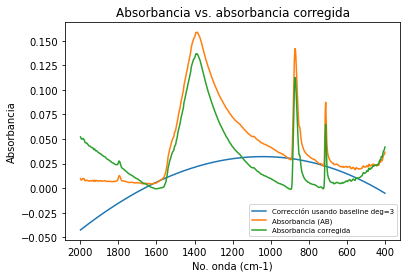

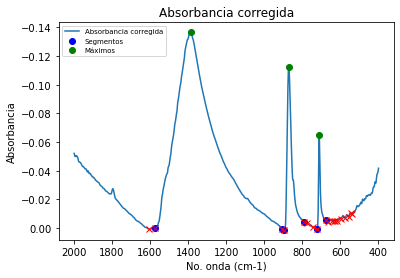


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 0
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 1572.43344
Boundary No de onda:
 904.71596
--------------------------------------------------
No. de onda del máximo del pico: 1384.89551
Área del pico:  32.921880896545794
Absorbancia (Alpha Brucker):  0.15868
Absorbancia corregida:  0.13653379254667747

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 1
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 894.41168
Boundary No de onda:
 791.3688599999999
--------------------------------------------------
No. de onda del máximo del pico: 871.74226
Área del pico:  3.359597924992244
Absorbancia (Alpha Brucker):  0.14207
Absorbancia corregida:  0.11255860766512532

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 2
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 723.3606
Boundary No de onda:
 675.9609
--------------------------------------------------
No. de onda d

In [241]:
CaCO3_data=pd.read_table('Datos_Rotativo/CaCO3.0.txt',sep=',')
analiza(CaCO3_data)

Holi estás en analiza
Output:
No. onda       float64
Absorbancia    float64
dtype: object
        No. onda  Absorbancia
969   1999.03072      0.00438
970   1996.96986      0.00436
971   1994.90900      0.00421
972   1992.84815      0.00414
973   1990.78729      0.00429
...          ...          ...
1741   408.04957      0.02742
1742   405.98871      0.02755
1743   403.92786      0.02735
1744   401.86700      0.02753
1745   399.80614      0.02752

[777 rows x 2 columns]
~PRIMER DERIVADA~
Hello from derivative
1999.03072
776
~SEGUNDA DERIVADA~
Hello from derivative
1999.03072
776
Picos usando peaks:  [258 554 624]
No de onda:
         No. onda  Absorbancia  Primer derivada  Segunda derivada
1227  1467.32976      0.23341         0.000046         -0.000304
1523   857.31627      0.18367         0.000519         -0.002090
1593   713.05632      0.07327         0.002429         -0.003876


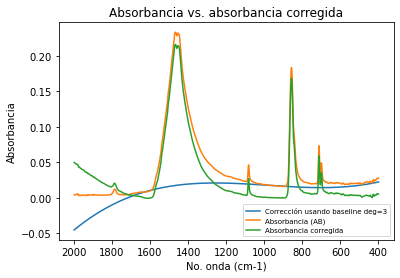

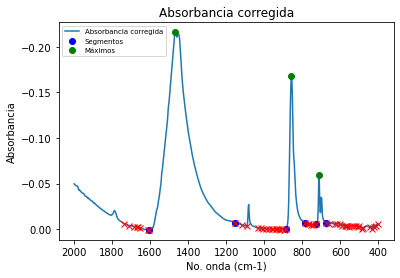


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 0
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 1603.34629
Boundary No de onda:
 1152.01873
--------------------------------------------------
No. de onda del máximo del pico: 1467.3297599999999
Área del pico:  30.786918624449385
Absorbancia (Alpha Brucker):  0.23340999999999998
Absorbancia corregida:  0.2160884959474605

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 1
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 888.22911
Boundary No de onda:
 785.18629
--------------------------------------------------
No. de onda del máximo del pico: 857.3162699999999
Área del pico:  4.6003722421020035
Absorbancia (Alpha Brucker):  0.18367
Absorbancia corregida:  0.16817724541939238

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 2
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 727.48231
Boundary No de onda:
 675.9609
------------------------------------------

In [242]:
Concha_data=pd.read_table('Datos_Rotativo/Concha.0.txt',sep=',')
analiza(Concha_data)

Holi estás en analiza
Output:
No. onda       float64
Absorbancia    float64
dtype: object
        No. onda  Absorbancia
969   1999.03072      0.00586
970   1996.96986      0.00590
971   1994.90900      0.00606
972   1992.84815      0.00614
973   1990.78729      0.00635
...          ...          ...
1741   408.04957      0.03203
1742   405.98871      0.03197
1743   403.92786      0.03211
1744   401.86700      0.03248
1745   399.80614      0.03426

[777 rows x 2 columns]
~PRIMER DERIVADA~
Hello from derivative
1999.03072
776
~SEGUNDA DERIVADA~
Hello from derivative
1999.03072
776
Entramos al if
Picos usando peaks:  [287 547 625]
No de onda:
         No. onda  Absorbancia  Primer derivada  Segunda derivada
1256  1407.56493      0.15386         0.000082         -0.000099
1516   871.74226      0.12736        -0.001582         -0.001523
1594   710.99546      0.07046        -0.001330         -0.002662


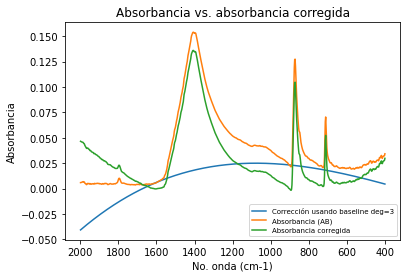

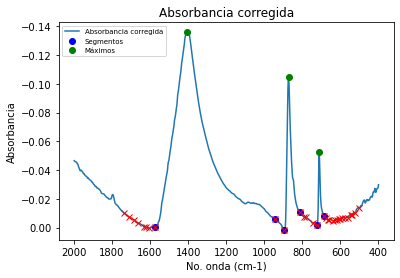


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 0
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 1572.43344
Boundary No de onda:
 945.93309
--------------------------------------------------
No. de onda del máximo del pico: 1407.56493
Área del pico:  28.853445268335637
Absorbancia (Alpha Brucker):  0.15386
Absorbancia corregida:  0.13596579224659994

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 1
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 894.41168
Boundary No de onda:
 814.03828
--------------------------------------------------
No. de onda del máximo del pico: 871.74226
Área del pico:  3.061879837805144
Absorbancia (Alpha Brucker):  0.12736
Absorbancia corregida:  0.10469100748162494

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 2
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 725.4214599999999
Boundary No de onda:
 686.26518
--------------------------------------------------
No. de onda

In [243]:
data2_600_0=pd.read_table('Datos_Rotativo/2-600.0.txt',sep=',')
analiza(data2_600_0)

Holi estás en analiza
Output:
No. onda       float64
Absorbancia    float64
dtype: object
        No. onda  Absorbancia
969   1999.03072      0.00855
970   1996.96986      0.00792
971   1994.90900      0.00743
972   1992.84815      0.00788
973   1990.78729      0.00816
...          ...          ...
1741   408.04957      0.03991
1742   405.98871      0.04083
1743   403.92786      0.04174
1744   401.86700      0.04175
1745   399.80614      0.04060

[777 rows x 2 columns]
~PRIMER DERIVADA~
Hello from derivative
1999.03072
776
~SEGUNDA DERIVADA~
Hello from derivative
1999.03072
776
Picos usando peaks:  [293 547 625]
No de onda:
         No. onda  Absorbancia  Primer derivada  Segunda derivada
1262  1395.19979      0.20718        -0.000034         -0.000179
1516   871.74226      0.17223        -0.001191         -0.002525
1594   710.99546      0.09084        -0.002591         -0.003716


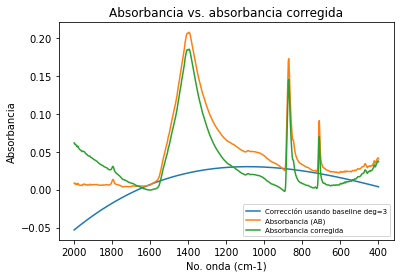

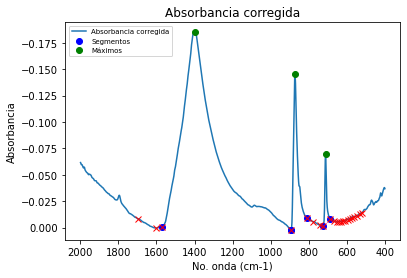


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 0
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 1572.43344
Boundary No de onda:
 894.41168
--------------------------------------------------
No. de onda del máximo del pico: 1395.1997900000001
Área del pico:  37.83956112974207
Absorbancia (Alpha Brucker):  0.20718000000000003
Absorbancia corregida:  0.18491346869839898

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 1
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 894.41168
Boundary No de onda:
 809.91657
--------------------------------------------------
No. de onda del máximo del pico: 871.74226
Área del pico:  3.8940334494322615
Absorbancia (Alpha Brucker):  0.17223
Absorbancia corregida:  0.14514118730129869

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 2
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 725.4214599999999
Boundary No de onda:
 686.26518
------------------------------------------

In [244]:
data2_600_1=pd.read_table('Datos_Rotativo/2-600.1.txt',sep=',')
analiza(data2_600_1)

Holi estás en analiza
Output:
No. onda       float64
Absorbancia    float64
dtype: object
        No. onda  Absorbancia
969   1999.03072      0.00444
970   1996.96986      0.00448
971   1994.90900      0.00477
972   1992.84815      0.00541
973   1990.78729      0.00626
...          ...          ...
1741   408.04957      0.05176
1742   405.98871      0.05158
1743   403.92786      0.05179
1744   401.86700      0.05399
1745   399.80614      0.05716

[777 rows x 2 columns]
~PRIMER DERIVADA~
Hello from derivative
1999.03072
776
~SEGUNDA DERIVADA~
Hello from derivative
1999.03072
776
Entramos al if
Picos usando peaks:  [289 547 625]
No de onda:
         No. onda  Absorbancia  Primer derivada  Segunda derivada
1258  1403.44321      0.18062         0.000087         -0.000145
1516   871.74226      0.15316        -0.001327         -0.003504
1594   710.99546      0.06699        -0.001148         -0.001530


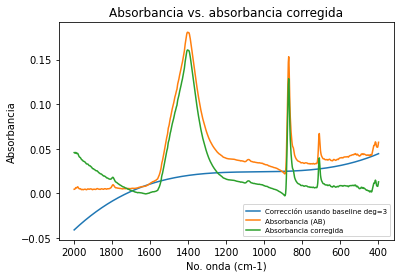

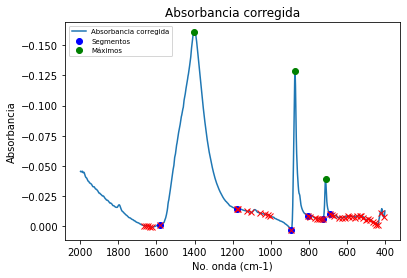


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 0
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 1582.7377199999999
Boundary No de onda:
 1178.8098699999998
--------------------------------------------------
No. de onda del máximo del pico: 1403.44321
Área del pico:  25.523058485314742
Absorbancia (Alpha Brucker):  0.18062
Absorbancia corregida:  0.1607499512155846

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 1
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 892.3508199999999
Boundary No de onda:
 805.79486
--------------------------------------------------
No. de onda del máximo del pico: 871.74226
Área del pico:  2.9157614188079
Absorbancia (Alpha Brucker):  0.15316
Absorbancia corregida:  0.1284215641697601

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 2
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 725.4214599999999
Boundary No de onda:
 688.32604
-----------------------------------------

In [245]:
data2_800_0=pd.read_table('Datos_Rotativo/2-800.0.txt',sep=',')
analiza(data2_800_0)

Holi estás en analiza
Output:
No. onda       float64
Absorbancia    float64
dtype: object
        No. onda  Absorbancia
969   1999.03072      0.00672
970   1996.96986      0.00666
971   1994.90900      0.00620
972   1992.84815      0.00591
973   1990.78729      0.00579
...          ...          ...
1741   408.04957      0.07005
1742   405.98871      0.07011
1743   403.92786      0.06990
1744   401.86700      0.06945
1745   399.80614      0.06947

[777 rows x 2 columns]
~PRIMER DERIVADA~
Hello from derivative
1999.03072
776
~SEGUNDA DERIVADA~
Hello from derivative
1999.03072
776
Entramos al if
Picos usando peaks:  [288 547 625]
No de onda:
         No. onda  Absorbancia  Primer derivada  Segunda derivada
1257  1405.50407      0.18213         0.000255         -0.000222
1516   871.74226      0.15700        -0.002458         -0.003476
1594   710.99546      0.07477        -0.000920         -0.001569


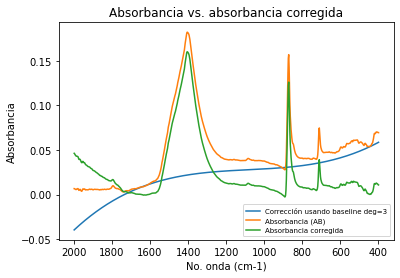

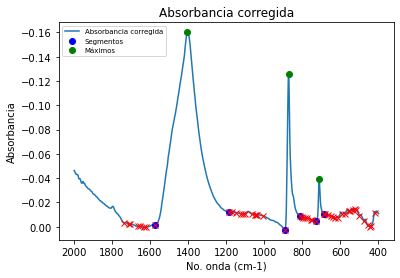


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 0
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 1576.55515
Boundary No de onda:
 1184.99243
--------------------------------------------------
No. de onda del máximo del pico: 1405.50407
Área del pico:  24.56677818913977
Absorbancia (Alpha Brucker):  0.18213
Absorbancia corregida:  0.16019930887469716

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 1
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 892.3508199999999
Boundary No de onda:
 811.97742
--------------------------------------------------
No. de onda del máximo del pico: 871.74226
Área del pico:  2.7790059593295733
Absorbancia (Alpha Brucker):  0.157
Absorbancia corregida:  0.1261920608652505

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 2
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 727.48231
Boundary No de onda:
 686.26518
--------------------------------------------------
No. de onda d

In [246]:
data2_800_1=pd.read_table('Datos_Rotativo/2-800.1.txt',sep=',')
analiza(data2_800_1)

Holi estás en analiza
Output:
No. onda       float64
Absorbancia    float64
dtype: object
        No. onda  Absorbancia
969   1999.03072      0.00501
970   1996.96986      0.00456
971   1994.90900      0.00441
972   1992.84815      0.00489
973   1990.78729      0.00565
...          ...          ...
1741   408.04957      0.06900
1742   405.98871      0.06896
1743   403.92786      0.07063
1744   401.86700      0.07281
1745   399.80614      0.07530

[777 rows x 2 columns]
~PRIMER DERIVADA~
Hello from derivative
1999.03072
776
~SEGUNDA DERIVADA~
Hello from derivative
1999.03072
776
Entramos al if
Picos usando peaks:  [289 547 625]
No de onda:
         No. onda  Absorbancia  Primer derivada  Segunda derivada
1258  1403.44321      0.29991         0.000279         -0.000338
1516   871.74226      0.21880        -0.007131         -0.006939
1594   710.99546      0.07810        -0.002974         -0.001811


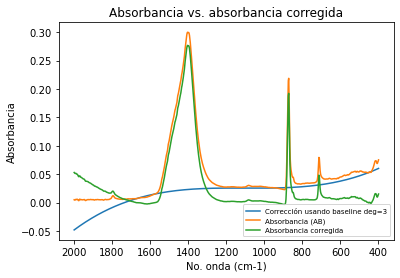

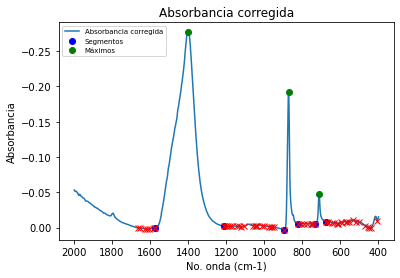


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 0
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 1572.43344
Boundary No de onda:
 1209.72271
--------------------------------------------------
No. de onda del máximo del pico: 1403.44321
Área del pico:  33.227213062141885
Absorbancia (Alpha Brucker):  0.29991
Absorbancia corregida:  0.2768100976980631

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 1
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 894.41168
Boundary No de onda:
 824.3425599999999
--------------------------------------------------
No. de onda del máximo del pico: 871.74226
Área del pico:  3.0059400331089217
Absorbancia (Alpha Brucker):  0.2188
Absorbancia corregida:  0.19228196154590754

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 2
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 733.6648799999999
Boundary No de onda:
 675.9609
--------------------------------------------------
No. 

In [247]:
data2_1000_0=pd.read_table('Datos_Rotativo/2-1000.0.txt',sep=',')
analiza(data2_1000_0)

Holi estás en analiza
Output:
No. onda       float64
Absorbancia    float64
dtype: object
        No. onda  Absorbancia
969   1999.03072      0.00525
970   1996.96986      0.00515
971   1994.90900      0.00497
972   1992.84815      0.00497
973   1990.78729      0.00530
...          ...          ...
1741   408.04957      0.06067
1742   405.98871      0.06164
1743   403.92786      0.06194
1744   401.86700      0.06183
1745   399.80614      0.06365

[777 rows x 2 columns]
~PRIMER DERIVADA~
Hello from derivative
1999.03072
776
~SEGUNDA DERIVADA~
Hello from derivative
1999.03072
776
Picos usando peaks:  [292 547 624]
No de onda:
         No. onda  Absorbancia  Primer derivada  Segunda derivada
1261  1397.26064      0.42419        -0.000354         -0.000506
1516   871.74226      0.28657        -0.010253         -0.010098
1593   713.05632      0.08864         0.003462         -0.002994


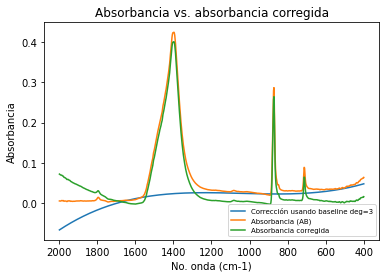

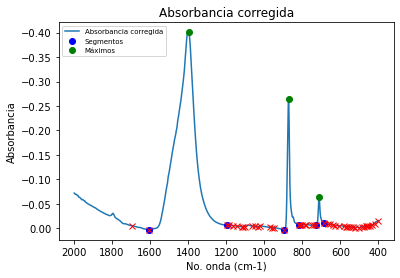


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 0
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 1605.40714
Boundary No de onda:
 1197.35757
--------------------------------------------------
No. de onda del máximo del pico: 1397.26064
Área del pico:  45.77585321478594
Absorbancia (Alpha Brucker):  0.42418999999999996
Absorbancia corregida:  0.40072366829557005

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 1
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 894.41168
Boundary No de onda:
 818.15999
--------------------------------------------------
No. de onda del máximo del pico: 871.74226
Área del pico:  4.095366686737996
Absorbancia (Alpha Brucker):  0.28657
Absorbancia corregida:  0.26404321704338374

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PICO NO. 2
IMPRIMIMOS LOS DOS EXTREMOS DE INTEGRACION
Boundary No de onda:
 727.48231
Boundary No de onda:
 686.26518
--------------------------------------------------
No. de 

In [248]:
data2_1000_1=pd.read_table('Datos_Rotativo/2-1000.1.txt',sep=',')
analiza(data2_1000_1)